# Taxi Demand Forecasting

## model

### importing data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [4]:
df = pd.read_csv("dataset.csv")
df.head()


,Unnamed: 0,timestamp,value
0,0,2014-07-01 00:00:00,10844
1,1,2014-07-01 00:30:00,8127
2,2,2014-07-01 01:00:00,6210
3,3,2014-07-01 01:30:00,4656
4,4,2014-07-01 02:00:00,3820


### Cleaning the Dataset

In [5]:
# Drop unwanted index column
df = df.drop(columns=["Unnamed: 0"])

# Convert timestamp column to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort data by time
df = df.sort_values("timestamp").reset_index(drop=True)


### Understand the Data Visually

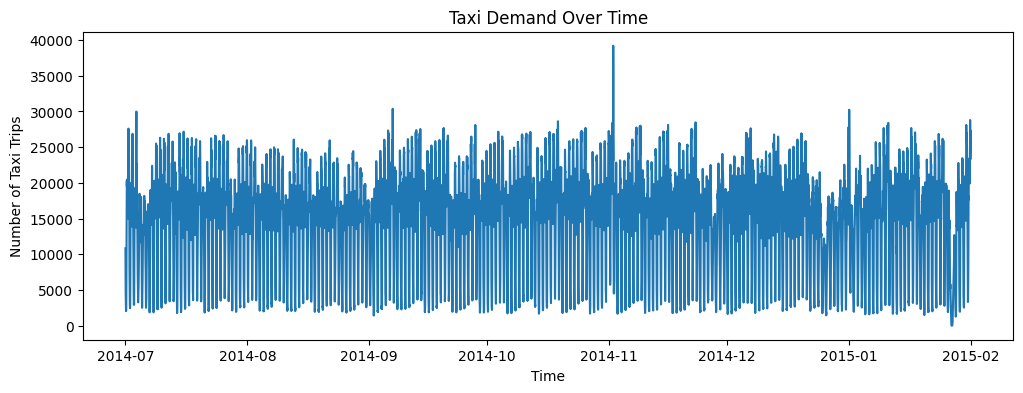

In [6]:
plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["value"])
plt.title("Taxi Demand Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Taxi Trips")
plt.show()


### Normalize Taxi Demand Values

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df["value_scaled"] = scaler.fit_transform(df[["value"]])


### Create Time Series Sequences

In [13]:
WINDOW_SIZE = 48   # past 48 time steps
HORIZON = 1        # predict next step

def create_sequences(data, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + horizon])
    return np.array(X), np.array(y)

values = df["value_scaled"].values
X, y = create_sequences(values, WINDOW_SIZE, HORIZON)


### Train and Test Split

In [14]:
split_index = int(0.8 * len(X))

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]


### Convert Data to PyTorch Tensors

In [15]:
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32)


### Create Dataset and DataLoader

In [16]:
class TaxiDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TaxiDataset(X_train, y_train)
test_dataset = TaxiDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### Build the LSTM Model

In [17]:
class TaxiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, HORIZON)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        out = self.fc(out)
        return out


### Define Loss and Optimizer


In [18]:
model = TaxiLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Train the Model

In [19]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}")


Epoch 1, Training Loss: 3.6701
Epoch 2, Training Loss: 0.8170
Epoch 3, Training Loss: 0.5717
Epoch 4, Training Loss: 0.4014
Epoch 5, Training Loss: 0.2880
Epoch 6, Training Loss: 0.2351
Epoch 7, Training Loss: 0.1906
Epoch 8, Training Loss: 0.1605
Epoch 9, Training Loss: 0.1368
Epoch 10, Training Loss: 0.1270


### Evaluate the Model

In [20]:
model.eval()
predictions = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        preds = model(X_batch)
        predictions.append(preds)

predictions = torch.cat(predictions).numpy()


### Convert Predictions Back to Original Scale

In [21]:
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.numpy())


## Prediction

### Visualize Prediction vs Actual

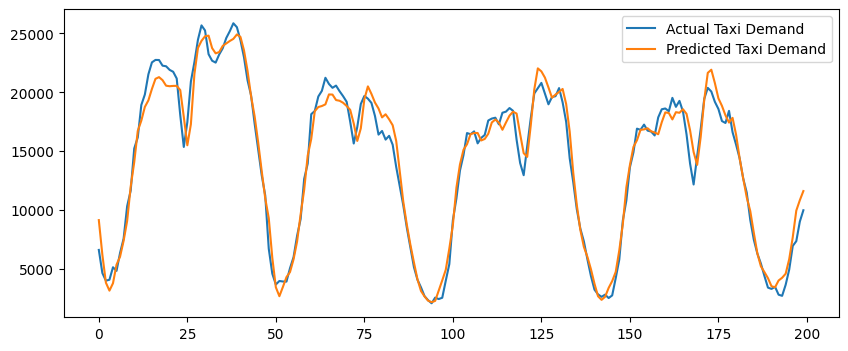

In [22]:
plt.figure(figsize=(10,4))
plt.plot(actual[:200], label="Actual Taxi Demand")
plt.plot(predictions[:200], label="Predicted Taxi Demand")
plt.legend()
plt.show()
